# Clustering the Alanine Dipeptide using Metadynamics Weights

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch import torch_sgmm
import torch

## Read trajectory

Read the trajectory.  This trajectory contains 100k frames of alanine dipeptide (ADP) run with standard metadynamics.  Details of the simulation can be found in the input file but what is most important here is that this is a biased MD simulation.  Thus each frame does contribute equally to the unbiased distribution.  

In [2]:
prmtopFileName = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
trajFileName = "run_ala2_metad_sigma0.3_height1.2_pace500.xtc"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('name C N CA')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms in selection: 5


## Perform Cross Validation with Uniform Weights

We will start by assuming each frame has equal weight.  This is wrong but will serve as a reference.  We will use the the cross validation script contained in the shapeGMM scripts file.

In [3]:
# scripts contains a built-in CV routine
from shapeGMMTorch import scripts

We will scan from 1 to 6 clusters.

In [4]:
# define cluster array
cluster_array = np.arange(1,7,1).astype(int)

In [7]:
# uniform weights
train, cv = scripts.cross_validate_cluster_scan(traj_data, 10000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 10, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 10000
Number of frames to predict each model: 90001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              19.693          29.432
              1               2               1              20.730          62.169
              1               2               2              20.735          84.353
              1               2               3              20.731          68.888
              1               2               4              20.730          71.162
              1               2               5              20.735          63.000
              1               2               6              20.731          71.293
              1               2               7              20.5

              2               6               3              22.204         236.029
              2               6               4              22.019         181.597
              2               6               5              22.111         266.205
              2               6               6              22.398         162.568
              2               6               7              22.156         197.467
              2               6               8              22.590         308.588
              2               6               9              22.256         256.666
              2               6              10              22.176         237.120
              3               1               1              19.711          41.466
              3               2               1              20.756         105.268
              3               2               2              20.755          94.330
              3               2               3              20.756         

## Perform Cross Validation with MetaD Weights for each Frame

We will read the metadynamics weight from the colvar file.  ***Note that there are various ways of determining a weight per frame from metadynamics simulations.  Here we will choose the exponential of $V(s,t)-c(t)$.***

In [5]:
# load the weights from c(t)/rbias column in the metaD colvars file
frame_weights = np.loadtxt("run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat",comments="#")[:,-2]
# exponential
frame_weights = np.exp(frame_weights/0.593)
# normalize
frame_weights /= np.sum(frame_weights)
print(np.sum(frame_weights))

1.0


In [7]:
# CV scan with non-uniform weights
metaD_train, metaD_cv = scripts.cross_validate_cluster_scan(traj_data, 10000, frame_weights = frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 10, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 10000
Number of frames to predict each model: 90001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              22.585          23.622
              1               2               1              25.575          30.933
              1               2               2              25.557          23.541
              1               2               3              25.603          41.794
              1               2               4              25.715          88.896
              1               2               5              25.576          27.259
              1               2               6              25.603          48.322
              1               2               7              25.5

              2               6               3              29.265         260.925
              2               6               4              27.888          64.916
              2               6               5              28.851          76.665
              2               6               6              28.352          63.883
              2               6               7              28.961         104.842
              2               6               8              28.904         106.880
              2               6               9              29.051         103.534
              2               6              10              27.831         102.668
              3               1               1              22.500          84.611
              3               2               1              23.167          33.326
              3               2               2              25.256          44.788
              3               2               3              25.375         

### Save and load log likelihood data for quick use

In [9]:
# save data (optional - don't have to do this)
#np.savetxt("uniform_frame_weights_ll_train_5atoms.dat", train)
#np.savetxt("uniform_frame_weights_ll_cv_5atoms.dat", cv)
np.savetxt("metaD_frame_weights_ll_train_5atoms.dat", metaD_train)
np.savetxt("metaD_frame_weights_ll_cv_5atoms.dat", metaD_cv)

In [10]:
# load data
# NOTE - only do this if you want to overwrite active arrays
train = np.loadtxt("uniform_frame_weights_ll_train_5atoms.dat")
cv = np.loadtxt("uniform_frame_weights_ll_cv_5atoms.dat")
#metaD_train = np.loadtxt("metaD_frame_weights_ll_train_5atoms.dat")
#metaD_cv = np.loadtxt("metaD_frame_weights_ll_cv_5atoms.dat")

## Make Log Likelihood vs number of Cluster Plots

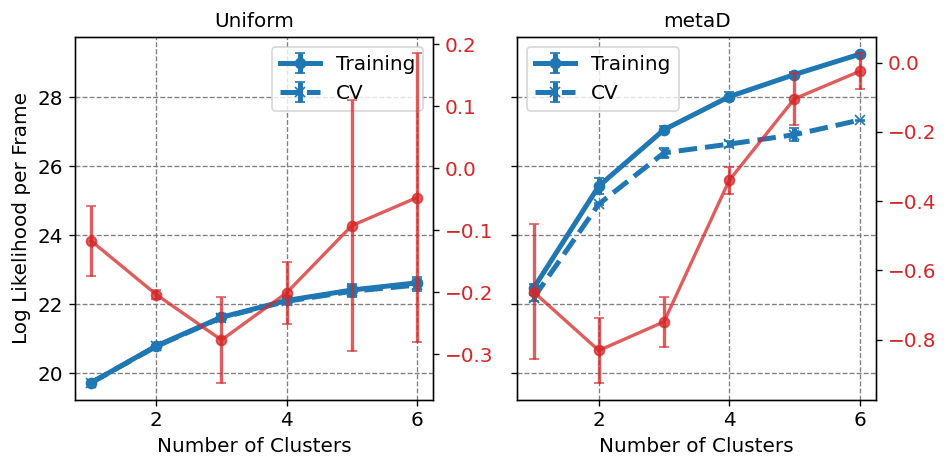

In [11]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch import plots
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,2,figsize=(8,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform",fontsize=12)
plots.plot_log_likelihood_with_dd(ax[0],cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=False,xlabel=True)
# metaD Weights
ax[1].set_title("metaD",fontsize=12)
plots.plot_log_likelihood_with_dd(ax[1],cluster_array,metaD_train,metaD_cv,fontsize=12,ylabel1=False,ylabel2=False,xlabel=True)
plt.tight_layout()
plt.show()

## Fit a $n_{clusters}=4$ object with metaD weights

In [6]:
# fit a shapeGMM object for n=4 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights_4clusters = scripts.sgmm_fit_with_attempts(traj_data[::2], 4, 10, frame_weights[::2],device=torch.device("cpu"))

Number of training frames: 50001
Number of clusters: 4
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              27.322         314.079
       2              27.239         193.090
       3              27.211         187.458
       4              27.138         187.819
       5              27.339         346.273
       6              27.141         228.883
       7              27.285         272.523
       8              27.284         391.373
       9              27.223         231.936
      10              27.233         214.351


In [49]:
# save object
import pickle
fileObj = open('sgmm_4clusters_metaD_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_metaD_weights_4clusters,fileObj)
fileObj.close()

## Fit a $n_{clusters}=3$ object with metaD weights

In [ ]:
# fit a shapeGMM object for n=3 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights = scripts.sgmm_fit_with_attempts(traj_data[::2], 3, 10, frame_weights[::2],device=torch.device("cpu"))

Number of training frames: 50001
Number of clusters: 3
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              26.734         272.034
       2              26.479         303.235
       3              25.977         207.432
       4              26.736         363.527


In [62]:
# save object
import pickle
fileObj = open('sgmm_3clusters_metaD_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_metaD_weights,fileObj)
fileObj.close()

## Fit a $n_{clusters}=2$ object with metaD weights

In [ ]:
# fit a shapeGMM object for n=2 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights_2clusters = scripts.sgmm_fit_with_attempts(traj_data[::2], 2, 10, frame_weights[::2],device=torch.device("cpu"))

In [63]:
# save object
import pickle
fileObj = open('sgmm_2clusters_metaD_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_metaD_weights_2clusters,fileObj)
fileObj.close()

## Fit a $n_{clusters}=3$ object with uniform frame weights

In [65]:
# fit a shapeGMM object for n=4 with uniform weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_uniform_weights = scripts.sgmm_fit_with_attempts(traj_data, 3, 30, np.ones(frame_weights.shape),device=torch.device("cpu"))

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 30
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              21.547        1376.546
       2              21.045         732.411
       3              21.556        1595.707
       4              21.137         952.789
       5              21.547        1395.767
       6              21.074         839.038
       7              21.547        1583.228
       8              21.551        1312.588
       9              21.230         886.021
      10              21.230         937.797
      11              21.227        1175.582
      12              21.547        1422.289
      13              21.547        1019.711
      14              21.547        1435.538
      15              21.548         942.510
      16              21.194         725.901
      17              21.232        1320.416
      18              21.222        1070.084
      19       

In [66]:
# save object
import pickle
fileObj = open('sgmm_3clusters_uniform_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_uniform_weights,fileObj)
fileObj.close()

In [16]:
# load object
import pickle
fileObj = open('sgmm_3clusters_uniform_weights_5atoms.obj', 'rb')
sgmm_uniform_weights = pickle.load(fileObj)
fileObj.close()

## Ramachandran Plots

In [17]:
# compute phi psi
from MDAnalysis.analysis import dihedrals
protein = coord.select_atoms("protein")
rama = dihedrals.Ramachandran(protein).run()
print(rama.results.angles.shape)

(100001, 1, 2)


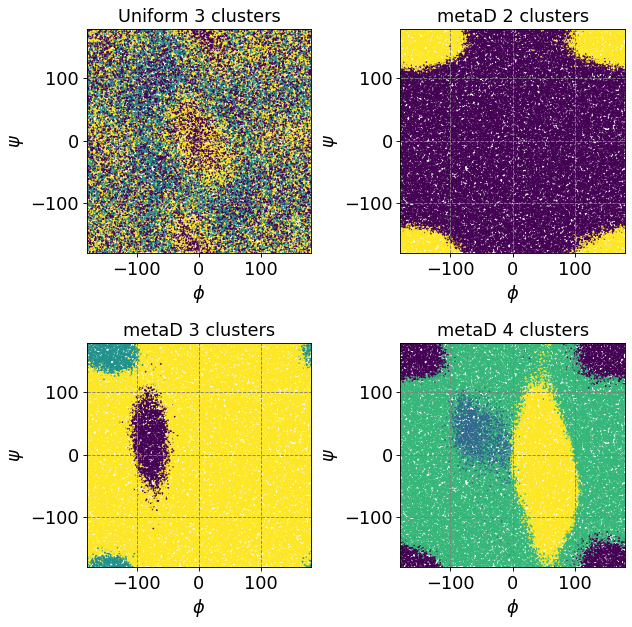

In [18]:
# Make Ramachandran plot
def rama_plot(ax,phi,psi,c,title,fontsize=16):
    # make a grid
    ax.grid(which='major', axis='both', color='#808080', linestyle='--')
    # set ticks and axis labels
    ax.tick_params(axis='both',labelsize=fontsize)
    ax.set_ylabel("$\psi$",fontsize=fontsize)
    ax.set_xlabel("$\phi$",fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    # scatter plot
    ax.scatter(phi, psi,c=c,s=0.4)
    # enforce range
    ax.set_ylim(-180,180)
    ax.set_xlim(-180,180)
    # equal aspect ratio
    ax.set_aspect("equal")



fontsize=16
phi = rama.results.angles[::2,0,0]
psi = rama.results.angles[::2,0,1]
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=80)
c = sgmm_uniform_weights.cluster_ids[::2]
rama_plot(ax[0,0],phi,psi,c,"Uniform 3 clusters")
c = sgmm_metaD_weights_2clusters.cluster_ids
rama_plot(ax[0,1],phi,psi,c,"metaD 2 clusters")
c = sgmm_metaD_weights.cluster_ids
rama_plot(ax[1,0],phi,psi,c,"metaD 3 clusters")
c = sgmm_metaD_weights_4clusters.cluster_ids
rama_plot(ax[1,1],phi,psi,c,"metaD 4 clusters")

#show plot
plt.tight_layout()
plt.show()

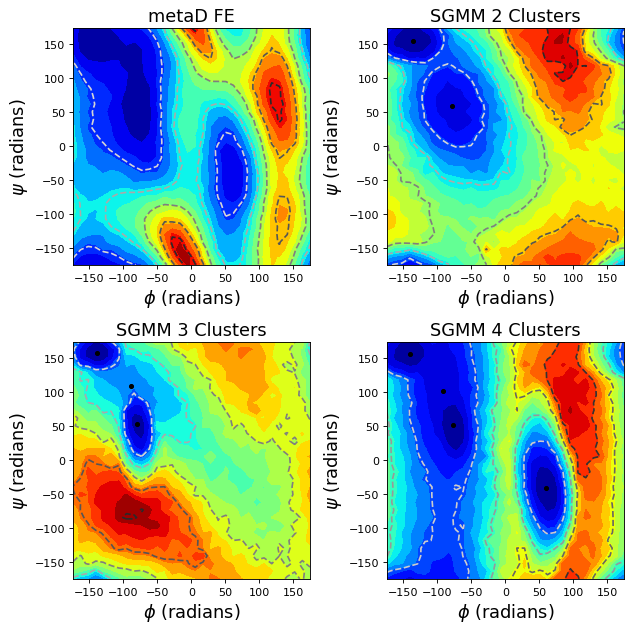

In [40]:
from MDAnalysis.lib.distances import calc_dihedrals
# make fe
def plot_rama_sgmm_fe(ax,fig,phi,psi,sgmm_obj,title,fontsize=16,contour_levels= np.arange(0,30,1)):
    nbins  = 32
    range_ = [-180,180]

    phis = calc_dihedrals(sgmm_obj.centers[:,0,:],sgmm_obj.centers[:,1,:],sgmm_obj.centers[:,2,:],sgmm_obj.centers[:,3,:])
    psis = calc_dihedrals(sgmm_obj.centers[:,1,:],sgmm_obj.centers[:,2,:],sgmm_obj.centers[:,3,:],sgmm_obj.centers[:,4,:])
    H, xedges, yedges = np.histogram2d(phi, psi, bins=nbins,\
                                   range=[range_, range_], weights=sgmm_obj.frame_weights*np.exp(sgmm_obj.train_frame_log_likelihood))
    bin_weights = np.histogram2d(phi, psi, bins=nbins,\
                                   range=[range_, range_], weights=sgmm_obj.frame_weights)[0]

    H = -np.log(H) + np.log(bin_weights)
    H = H.T
    H -= H.min()

    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2

    xx, yy = np.meshgrid(xcenters, ycenters)

    ax.set_xlabel("$\phi$ (radians)", fontsize=fontsize)
    ax.set_ylabel("$\psi$ (radians)", fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    ax.contour(xx, yy, H, cmap="binary", levels=5, linestyles="--")
    ax.contourf(xx, yy, H, cmap='jet', levels=20)
    #ax.set_clim(0,50)
    #cbar = fig.colorbar()
    #cbar.set_label("FE/kT", fontsize=fontsize)
    ax.scatter(phis*180/np.pi, psis*180/np.pi, marker='.', s=50.5, color="black")

def plot_rama_metaD_fe(ax,fig,phi,psi,rbias,title,fontsize=16,contour_levels= np.arange(0,30,1)):
    nbins  = 32
    range_ = [-180,180]
    kt = 0.596161
    
    H, xedges, yedges = np.histogram2d(phi, psi, bins=nbins,\
                                   range=[range_, range_], weights=np.exp(rbias/kt))

    H = -np.log(H.T)
    #H *= gamma/(gamma-1)   #! check here it is mutiplied by pre-factor!!
    H *= kt  #! check here multiplying by kt
    H -= H.min()

    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2

    xx, yy = np.meshgrid(xcenters, ycenters)

    ax.set_xlabel("$\phi$ (radians)", fontsize=fontsize)
    ax.set_ylabel("$\psi$ (radians)", fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    ax.contour(xx, yy, H, cmap="binary", levels=5, linestyles="--")
    ax.contourf(xx, yy, H, cmap='jet', levels=20)
    #plt.clim(0,50)
    #cbar = fig.colorbar()
    #cbar.set_label("FE/kT", fontsize=fontsize)

    
phi = rama.results.angles[:,0,0]
psi = rama.results.angles[:,0,1]

fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=80)
contour_levels = np.arange(0,25,2)
# metaD FE
rbias = np.loadtxt("run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat",comments="#")[:,-2]
plot_rama_metaD_fe(ax[0,0],fig,phi,psi,rbias,"metaD FE",contour_levels=contour_levels)
# 2 clusters
plot_rama_sgmm_fe(ax[0,1],fig,phi[::2],psi[::2],sgmm_metaD_weights_2clusters,"SGMM 2 Clusters")
# 3 clusters
plot_rama_sgmm_fe(ax[1,0],fig,phi[::2],psi[::2],sgmm_metaD_weights,"SGMM 3 Clusters")
# 4 clusters
plot_rama_sgmm_fe(ax[1,1],fig,phi[::2],psi[::2],sgmm_metaD_weights_4clusters,"SGMM 4 Clusters")

#show plot
plt.tight_layout()
plt.show()